# ehrMGAN: Electronic Health Records Multiple Generative Adversarial Networks
This notebook implements the complete ehrMGAN model for generating synthetic electronic health records data. The model combines VAEs and GANs to generate both continuous (vital signs) and discrete (medications/interventions) time series data.

## 1. Environment Setup
First, let's set up our environment with the necessary imports and check the configuration.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories if they don't exist
os.makedirs("data/checkpoint/", exist_ok=True)
os.makedirs("data/fake/", exist_ok=True)
os.makedirs("logs/", exist_ok=True)

# Environment information
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages

TensorFlow version: 1.14.0
NumPy version: 1.19.5
Pandas version: 1.1.5


In [2]:
import platform
import psutil
import GPUtil

# System info
print(f"System: {platform.system()} {platform.version()}")
print(f"Python version: {platform.python_version()}")
print(f"Processor: {platform.processor()}")

# Memory info
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")

# GPU info
try:
    gpus = GPUtil.getGPUs()
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}, Memory: {gpu.memoryTotal} MB")
            print(f"   Memory used: {gpu.memoryUsed} MB, Load: {gpu.load*100:.1f}%")
    else:
        print("No GPU detected")
except:
    print("Could not detect GPU information")

# Check if TensorFlow sees GPUs
print("\nTensorFlow GPU availability:")
print(f"GPU available: {tf.test.is_gpu_available()}")

System: Windows 10.0.19041
Python version: 3.6.15
Processor: AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
Total memory: 31.93 GB
Available memory: 21.66 GB
GPU 0: NVIDIA GeForce RTX 3060, Memory: 12288.0 MB
   Memory used: 645.0 MB, Load: 5.0%

TensorFlow GPU availability:
GPU available: False


### 2. Import Model Components
Now let's import the necessary model components from our files.

In [3]:
# Import the model components
import sys
sys.path.append('.')

# Let's first import the necessary modules
from networks import C_VAE_NET, D_VAE_NET, C_GAN_NET, D_GAN_NET
from m3gan import m3gan
from utils import renormlizer
from visualise import visualise_gan, visualise_vae

### 3. Data Loading and Preprocessing
Let's load and preprocess the data.

In [4]:
# Data parameters
patinet_num = 16062
filename_postfix = '5_var'

# Load continuous data (vital signs)
continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
continuous_x = continuous_x.reshape(patinet_num, 24, 5)
print(f"Continuous data shape: {continuous_x.shape}")

# Load discrete data (medications/interventions)
discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
discrete_x = discrete_x.reshape(patinet_num, 24, 1)
print(f"Discrete data shape: {discrete_x.shape}")

# Load static data (patient demographics)
statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])
print(f"Static labels shape: {statics_label.shape}")

# Data statistics
print("\nContinuous data statistics:")
print(f"Mean: {np.mean(continuous_x, axis=(0,1))}")
print(f"Std: {np.std(continuous_x, axis=(0,1))}")
print(f"Min: {np.min(continuous_x, axis=(0,1))}")
print(f"Max: {np.max(continuous_x, axis=(0,1))}")

print("\nDiscrete data statistics:")
print(f"Mean: {np.mean(discrete_x)}")
print(f"Std: {np.std(discrete_x)}")
print(f"Min: {np.min(discrete_x)}")
print(f"Max: {np.max(discrete_x)}")

# Optional: Use a subset for faster experimentation
use_subset = False
subset_size = 5000
if use_subset:
    indices = np.random.choice(continuous_x.shape[0], subset_size, replace=False)
    continuous_x = continuous_x[indices]
    discrete_x = discrete_x[indices]
    statics_label = statics_label[indices]
    print(f"\nUsing subset of data: {subset_size} samples")

Continuous data shape: (16062, 24, 5)
Discrete data shape: (16062, 24, 1)
Static labels shape: (16062, 1)

Continuous data statistics:
Mean: [0.39582974 0.64002727 0.95716821 0.33487669 0.39307435]
Std: [0.07905853 0.17579326 0.05761428 0.18632828 0.12541822]
Min: [0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1.]

Discrete data statistics:
Mean: 0.5533661229402731
Std: 0.4971438996129025
Min: 0.0
Max: 1.0


### 4. Model Configuration and Hyperparameter Tuning
Let's define our hyperparameters based on the data dimensions.

In [ ]:
# Configure hyperparameters based on data dimensions
time_steps = continuous_x.shape[1]  # 24 hours
c_dim = continuous_x.shape[2]       # 5 continuous features
d_dim = discrete_x.shape[2]         # 1 discrete feature
num_samples = continuous_x.shape[0] # Number of patients

# Latent space dimensions
# For complex data with higher dimensions, we need a larger latent space
shared_latent_dim = 15 
c_z_size = shared_latent_dim
c_noise_dim = max(2, int(c_dim/2))  # At least 2 dimensions
d_z_size = shared_latent_dim
d_noise_dim = max(1, int(d_dim/2))  # At least 1 dimension

# Network sizes - scale based on data complexity
batch_size = 1024  # Can be adjusted based on memory constraints
enc_dec_size = 128  # For 5 features, 128 is reasonable
enc_dec_layers = 2  # For 24 time steps, 2-3 layers is reasonable
gen_units = 256     # For generation quality
gen_layers = 2
disc_units = 128
disc_layers = 2
dropout_keep = 0.8  # 0.8 is typically good for medical data

# Learning rates - typically smaller for stable training
v_lr_pre = 0.0005   # VAE pretraining
v_lr = 0.0001       # VAE fine-tuning
g_lr = 0.0001       # Generator
d_lr = 0.0001       # Discriminator

# Training parameters
use_subset = True
if use_subset:
    num_pre_epochs = 6
    num_epochs = 10
else:
    num_pre_epochs = 300  # For 16K patients, 300 pre-epochs should be sufficient
    num_epochs = 500      # For GAN stability, 500 epochs should work well
d_rounds = 1          # Standard practice
g_rounds = 3          # Multiple generator updates per discriminator update
v_rounds = 1          # VAE updates

# Loss weights
alpha_re = 1.0    # Reconstruction weight (primary objective)
alpha_kl = 0.5    # KL divergence weight
alpha_mt = 0.2    # Matching weight (increased for better coordination)
alpha_ct = 0.2    # Contrastive weight (increased for feature learning)
alpha_sm = 1.0    # Semantic weight

# GAN loss weights
c_beta_adv = 1.0   # Adversarial weight for continuous
c_beta_fm = 10.0   # Feature matching for continuous (reduced to prevent mode collapse)
d_beta_adv = 1.0   # Adversarial weight for discrete
d_beta_fm = 10.0   # Feature matching for discrete (reduced for stability)

# Regularization
l2_scale = 0.001   # L2 regularization

# Conditional GAN parameters
conditional = False  # Whether to use conditional GAN
num_labels = 1 if conditional else 0  # Number of conditional labels

# Display configuration
print("Model Configuration:")
print(f"Latent dimensions - Continuous: {c_z_size}, Discrete: {d_z_size}")
print(f"Noise dimensions - Continuous: {c_noise_dim}, Discrete: {d_noise_dim}")
print(f"Batch size: {batch_size}")
print(f"Pre-training epochs: {num_pre_epochs}, Training epochs: {num_epochs}")
print(f"Network sizes - Encoder/Decoder: {enc_dec_size}, Generator: {gen_units}, Discriminator: {disc_units}")
print(f"Network layers - Encoder/Decoder: {enc_dec_layers}, Generator: {gen_layers}, Discriminator: {disc_layers}")
print(f"Learning rates - VAE pre: {v_lr_pre}, VAE: {v_lr}, Generator: {g_lr}, Discriminator: {d_lr}")

Model Configuration:
Latent dimensions - Continuous: 15, Discrete: 15
Noise dimensions - Continuous: 2, Discrete: 1
Batch size: 1024
Pre-training epochs: 3, Training epochs: 5
Network sizes - Encoder/Decoder: 128, Generator: 256, Discriminator: 128
Network layers - Encoder/Decoder: 2, Generator: 2, Discriminator: 2
Learning rates - VAE pre: 0.0005, VAE: 0.0001, Generator: 0.0001, Discriminator: 0.0001


### 5. Build Model Components
Now let's build the model components.

In [6]:
# For TF1.x compatibility
tf.reset_default_graph()

# Define the VAE and GAN networks
c_vae = C_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=c_dim,
    z_dim=c_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

c_gan = C_GAN_NET(
    batch_size=batch_size,
    noise_dim=c_noise_dim,
    dim=c_dim,
    gen_dim=c_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_vae = D_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=d_dim,
    z_dim=d_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_gan = D_GAN_NET(
    batch_size=batch_size,
    noise_dim=d_noise_dim,
    dim=d_dim,
    gen_dim=d_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

### 6. Create and Train the Model
Now let's set up the complete model and train it.

In [ ]:
# Define checkpoint directory
checkpoint_dir = "data/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

# REPLACE the model building section (cell #6) with this:
# Reset the TensorFlow graph to avoid variable conflicts
tf.reset_default_graph()
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config=run_config)

# Create the complete M3GAN model
model = m3gan(
    sess=sess,
    batch_size=batch_size,
    time_steps=time_steps,
    num_pre_epochs=num_pre_epochs,
    num_epochs=num_epochs,
    checkpoint_dir=checkpoint_dir,
    epoch_ckpt_freq=100,  # Save checkpoint every 100 epochs
    epoch_loss_freq=1,   # Display loss every 10 epochs
    
    # Continuous parameters
    c_dim=c_dim,
    c_noise_dim=c_noise_dim,
    c_z_size=c_z_size,
    c_data_sample=continuous_x,
    c_vae=c_vae,
    c_gan=c_gan,
    
    # Discrete parameters
    d_dim=d_dim,
    d_noise_dim=d_noise_dim,
    d_z_size=d_z_size,
    d_data_sample=discrete_x,
    d_vae=d_vae,
    d_gan=d_gan,
    
    # Training parameters
    d_rounds=d_rounds,
    g_rounds=g_rounds,
    v_rounds=v_rounds,
    v_lr_pre=v_lr_pre,
    v_lr=v_lr,
    g_lr=g_lr,
    d_lr=d_lr,
    
    # Loss weights
    alpha_re=alpha_re,
    alpha_kl=alpha_kl,
    alpha_mt=alpha_mt,
    alpha_ct=alpha_ct,
    alpha_sm=alpha_sm,
    c_beta_adv=c_beta_adv,
    c_beta_fm=c_beta_fm,
    d_beta_adv=d_beta_adv,
    d_beta_fm=d_beta_fm,
    
    # Conditional parameters
    conditional=conditional,
    num_labels=num_labels,
    statics_label=statics_label
)

# Build the model
print("Building the model...")
model.build()

W0226 14:56:07.649376  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:118: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0226 14:56:07.649376  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:106: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0226 14:56:07.649376  6988 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:106: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0226 14:56:07.664733  6988 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:115: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.Sta

Building the model...


W0226 14:56:07.706216  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:46: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0226 14:56:07.710220  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:145: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0226 14:56:07.710220  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:147: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0226 14:56:07.746720  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of

W0226 14:56:07.833986  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:07.864873  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:07.963909  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:07.979967  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB78D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:08.027802  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.043420  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:08.146758  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.165510  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:08.211985  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.247323  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:08.330888  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.358173  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:08.419484  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.432245  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB78D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:08.537525  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.565806  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:08.597650  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.640285  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:08.824151  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:08.832584  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB78D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:09.047176  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:09.063837  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:09.196795  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:09.214296  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:09.397685  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:09.429484  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:09.581027  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:09.597156  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB78D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:09.813814  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:09.830464  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:10.014374  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:10.044331  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:10.164473  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:10.197144  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:10.380490  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:10.410136  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:10.566780  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:10.582735  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:10.765156  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:10.802126  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:10.914289  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:10.947675  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB77B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:11.114490  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB78D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB78D0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:11.148688  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:11.332925  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:11.349212  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:11.481114  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E728EB74E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:11.497627  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E728EB7668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:11.764551  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:11.786531  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:11.881254  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:11.914513  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:12.149114  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:12.163049  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:12.379451  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:12.399642  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:12.580452  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E094C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E094C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:12.598152  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:12.747893  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:12.764415  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:12.947878  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:12.981480  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:13.148224  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:13.165746  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E094C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:13.347937  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:13.365907  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:13.548585  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:13.584442  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:13.731384  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:13.747724  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:13.931368  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E094C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E094C50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:13.962773  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:14.196342  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:14.216743  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:14.431474  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:14.449328  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:14.597690  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:14.632316  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 14:56:14.814831  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:14.832486  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:14.997926  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:15.031805  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E094C50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 14:56:15.214857  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:15.232360  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:15.399159  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:15.430420  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:15.613776  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E143E10>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:15.629414  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72B6DFEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:15.817138  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:15.849143  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:16.012746  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:16.051723  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 14:56:16.231596  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:16.249635  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:16.579640  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:16.602080  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:16.798704  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E5309E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E5309E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:16.814928  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:16.980886  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:16.997074  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:17.184403  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:17.213429  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:17.385586  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:17.434630  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E5309E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:17.590772  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E5309E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E5309E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:17.620799  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 14:56:17.774940  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:17.792956  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:17.952101  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:17.984131  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:18.145277  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:18.176305  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:18.332511  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:18.349085  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:18.568381  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:18.591450  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:18.747925  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:18.784264  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:18.933887  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:18.970671  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:19.131688  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:19.168672  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72E5309E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:19.513706  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7315BAE48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:19.531434  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E73157A0F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:19.749061  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72EB59A58>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:19.767734  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:19.914809  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7314B1630>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:19.969767  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E731306390>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:20.141382  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:20.167406  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:20.314527  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:20.348520  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:20.502238  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:20.515476  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:20.700660  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:20.732128  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:20.898575  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:20.933384  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:21.114755  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:21.131092  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:21.318723  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:21.348040  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:21.481230  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:21.501153  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:21.680362  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:21.701299  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:21.882034  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:21.901473  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:22.083811  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:22.118582  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:22.281723  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:22.316403  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:22.501684  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 14:56:22.786363  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:22.817622  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 14:56:23.015936  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:23.033791  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:23.187413  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:23.218384  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:23.368107  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:23.401156  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:23.565205  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:23.601025  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:23.763678  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:23.782035  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E733F8DE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:23.966684  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:23.998007  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7323AD940>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:24.312864  6988 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:476: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0226 14:56:24.339576  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781DBF908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781DBF908>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 14:56:24.551497  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781EF9E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781EF9E48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:24.599656  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E731947B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E73

W0226 14:56:24.781088  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781E7BE80>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781E7BE80>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:24.833344  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E731947B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E73


W0226 14:56:24.999118  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E782689320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E782689320>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:25.056191  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7827F6780>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7

W0226 14:56:25.180975  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E782A0C6D8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E782A0C6D8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:25.237284  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7828B0EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78

W0226 14:56:25.381374  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78282DA58>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78282DA58>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:25.417662  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E781DBF908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78

W0226 14:56:25.597772  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E782EB79E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E782EB79E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:25.658014  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7824F0BE0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78


W0226 14:56:25.834456  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7830D55C0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7830D55C0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:25.881185  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E783121828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7

W0226 14:56:25.982375  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7833B5C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7833B5C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:26.032320  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E783163EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78


W0226 14:56:26.230360  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7835C6898>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7835C6898>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:26.280322  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78345DC88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7


W0226 14:56:26.417900  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7847E1470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7847E1470>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:26.464599  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78357A7B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7

W0226 14:56:26.566601  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E783674BE0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E783674BE0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 14:56:26.902989  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7837480B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E7837480B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:26.953992  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78357A7B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78


W0226 14:56:27.115434  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:27.151712  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:27.300995  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:27.331417  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:27.498194  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:27.536760  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:27.712644  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:27.729342  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:27.901718  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:27.936315  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:28.052516  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:28.082327  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:28.287898  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:28.317746  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:28.431854  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:28.467234  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7304802B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:28.632313  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7341540F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:28.663637  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7345B5C88>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:28.850170  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:28.868850  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:29.086391  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:29.108061  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:29.284952  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:29.314631  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:29.435230  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:29.462642  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:29.614804  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:29.651486  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:29.831311  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:29.847956  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:30.041353  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:30.068583  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:30.264623  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:30.286601  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 14:56:30.436967  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E72E1F4550>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:30.449541  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72BCA89E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:30.635413  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E72C0ECFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:30.681299  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\init_state.py:25: The name tf.nn.rnn_cell.LSTMStateTuple is deprecated. Please use tf.compat.v1.nn.rnn_cell.LSTMStateTuple instead.

W0226 14:56:30.697006  6988 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:398: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Pl

W0226 14:56:30.815270  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:30.830333  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:31.050814  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:31.065953  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:31.203557  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:31.215737  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:31.596152  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:31.631296  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:31.798672  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:31.834285  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:32.032306  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:32.048941  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:32.206854  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:32.238696  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python


W0226 14:56:32.398961  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:32.419950  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 14:56:32.582481  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7874AB908>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:32.598938  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:32.765085  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78717BF60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:32.797934  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:32.952468  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7874AB5F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:32.970163  6988 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:401: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0226 14:56:32.985187  6988 ag_logging.py:145] Entity <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x000001E733BA4208>> could not be transformed and will

W0226 14:56:33.152255  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:33.181317  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:33.331262  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:33.348005  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7860F5860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:33.562589  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:33.579193  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7860F5860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:33.752101  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:33.781251  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:33.918490  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:33.931981  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7860F5860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:34.151341  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:34.170589  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7860F5860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:34.315161  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7860F5860>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7860F5860>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:34.353967  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 14:56:34.502704  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:34.531270  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:34.715206  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E7871AB278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:34.750925  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E7872FAAC8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:34.912795  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:34.973088  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 14:56:35.098950  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:35.131277  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 14:56:35.315931  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:35.332257  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 14:56:35.485360  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:35.517594  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 14:56:35.699027  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:35.716580  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 14:56:35.915616  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:35.945905  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 14:56:36.102088  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:36.118580  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:36.303101  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:36.335132  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:36.450022  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:36.482530  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:36.654585  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E734564470>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:36.670818  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78786BFD0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 14:56:37.182021  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E78503E2B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:37.218480  6988 ag_logging.py:145] Entity <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x000001E735565198>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.co

W0226 14:56:37.386096  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:37.415574  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:37.579292  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E786CD4B00>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E786CD4B00>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:37.617638  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 14:56:37.769556  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:37.796903  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:37.997915  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:38.020927  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso


W0226 14:56:38.170165  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:38.186185  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E786CD4B00>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 14:56:38.381268  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:38.404509  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:38.532793  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:38.553211  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 14:56:38.753795  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:38.781217  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 14:56:38.901887  6988 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000001E789A86A90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:38.917598  6988 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000001E785A32048>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 14:56:39.083184  6988 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78B6B4C18>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000001E78B6B4C18>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 14:56:39.083184  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:229: The name tf.losses.mean_squared_error is deprecated. Please use tf.compat.v1.losses.mean_squared_error instead.

W0226 14:56:39.103568  6988 deprecation.py:323] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated an


W0226 14:56:39.595011  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:371: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0226 14:57:43.312219  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:406: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0226 14:57:43.312219  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:414: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0226 14:57:43.335182  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:478: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0226 14:57:43.335182  6988 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:98: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



Initializing or restoring model...
No checkpoint found, initializing variables
Starting training...
start pretraining
pretraining epoch 0
pretraining epoch 1
pretraining epoch 2
pretraining epoch 002: loss_cvae: 56.451 | loss_dvae: 46.462 | loss_matching: 0.641 | loss_contra: 189.624 
pretraining epoch 002: loss_cvae: 57.027 | loss_dvae: 45.901 | loss_matching: 0.635 | loss_contra: 185.333 
pretraining epoch 002: loss_cvae: 56.326 | loss_dvae: 44.841 | loss_matching: 0.621 | loss_contra: 178.879 
pretraining epoch 002: loss_cvae: 54.473 | loss_dvae: 44.019 | loss_matching: 0.605 | loss_contra: 173.625 
pretraining epoch 002: loss_cvae: 52.597 | loss_dvae: 44.937 | loss_matching: 0.617 | loss_contra: 177.240 
pretraining epoch 002: loss_cvae: 51.894 | loss_dvae: 48.395 | loss_matching: 0.668 | loss_contra: 193.659 
pretraining epoch 002: loss_cvae: 52.339 | loss_dvae: 48.701 | loss_matching: 0.662 | loss_contra: 193.963 
pretraining epoch 002: loss_cvae: 53.224 | loss_dvae: 43.528 | los

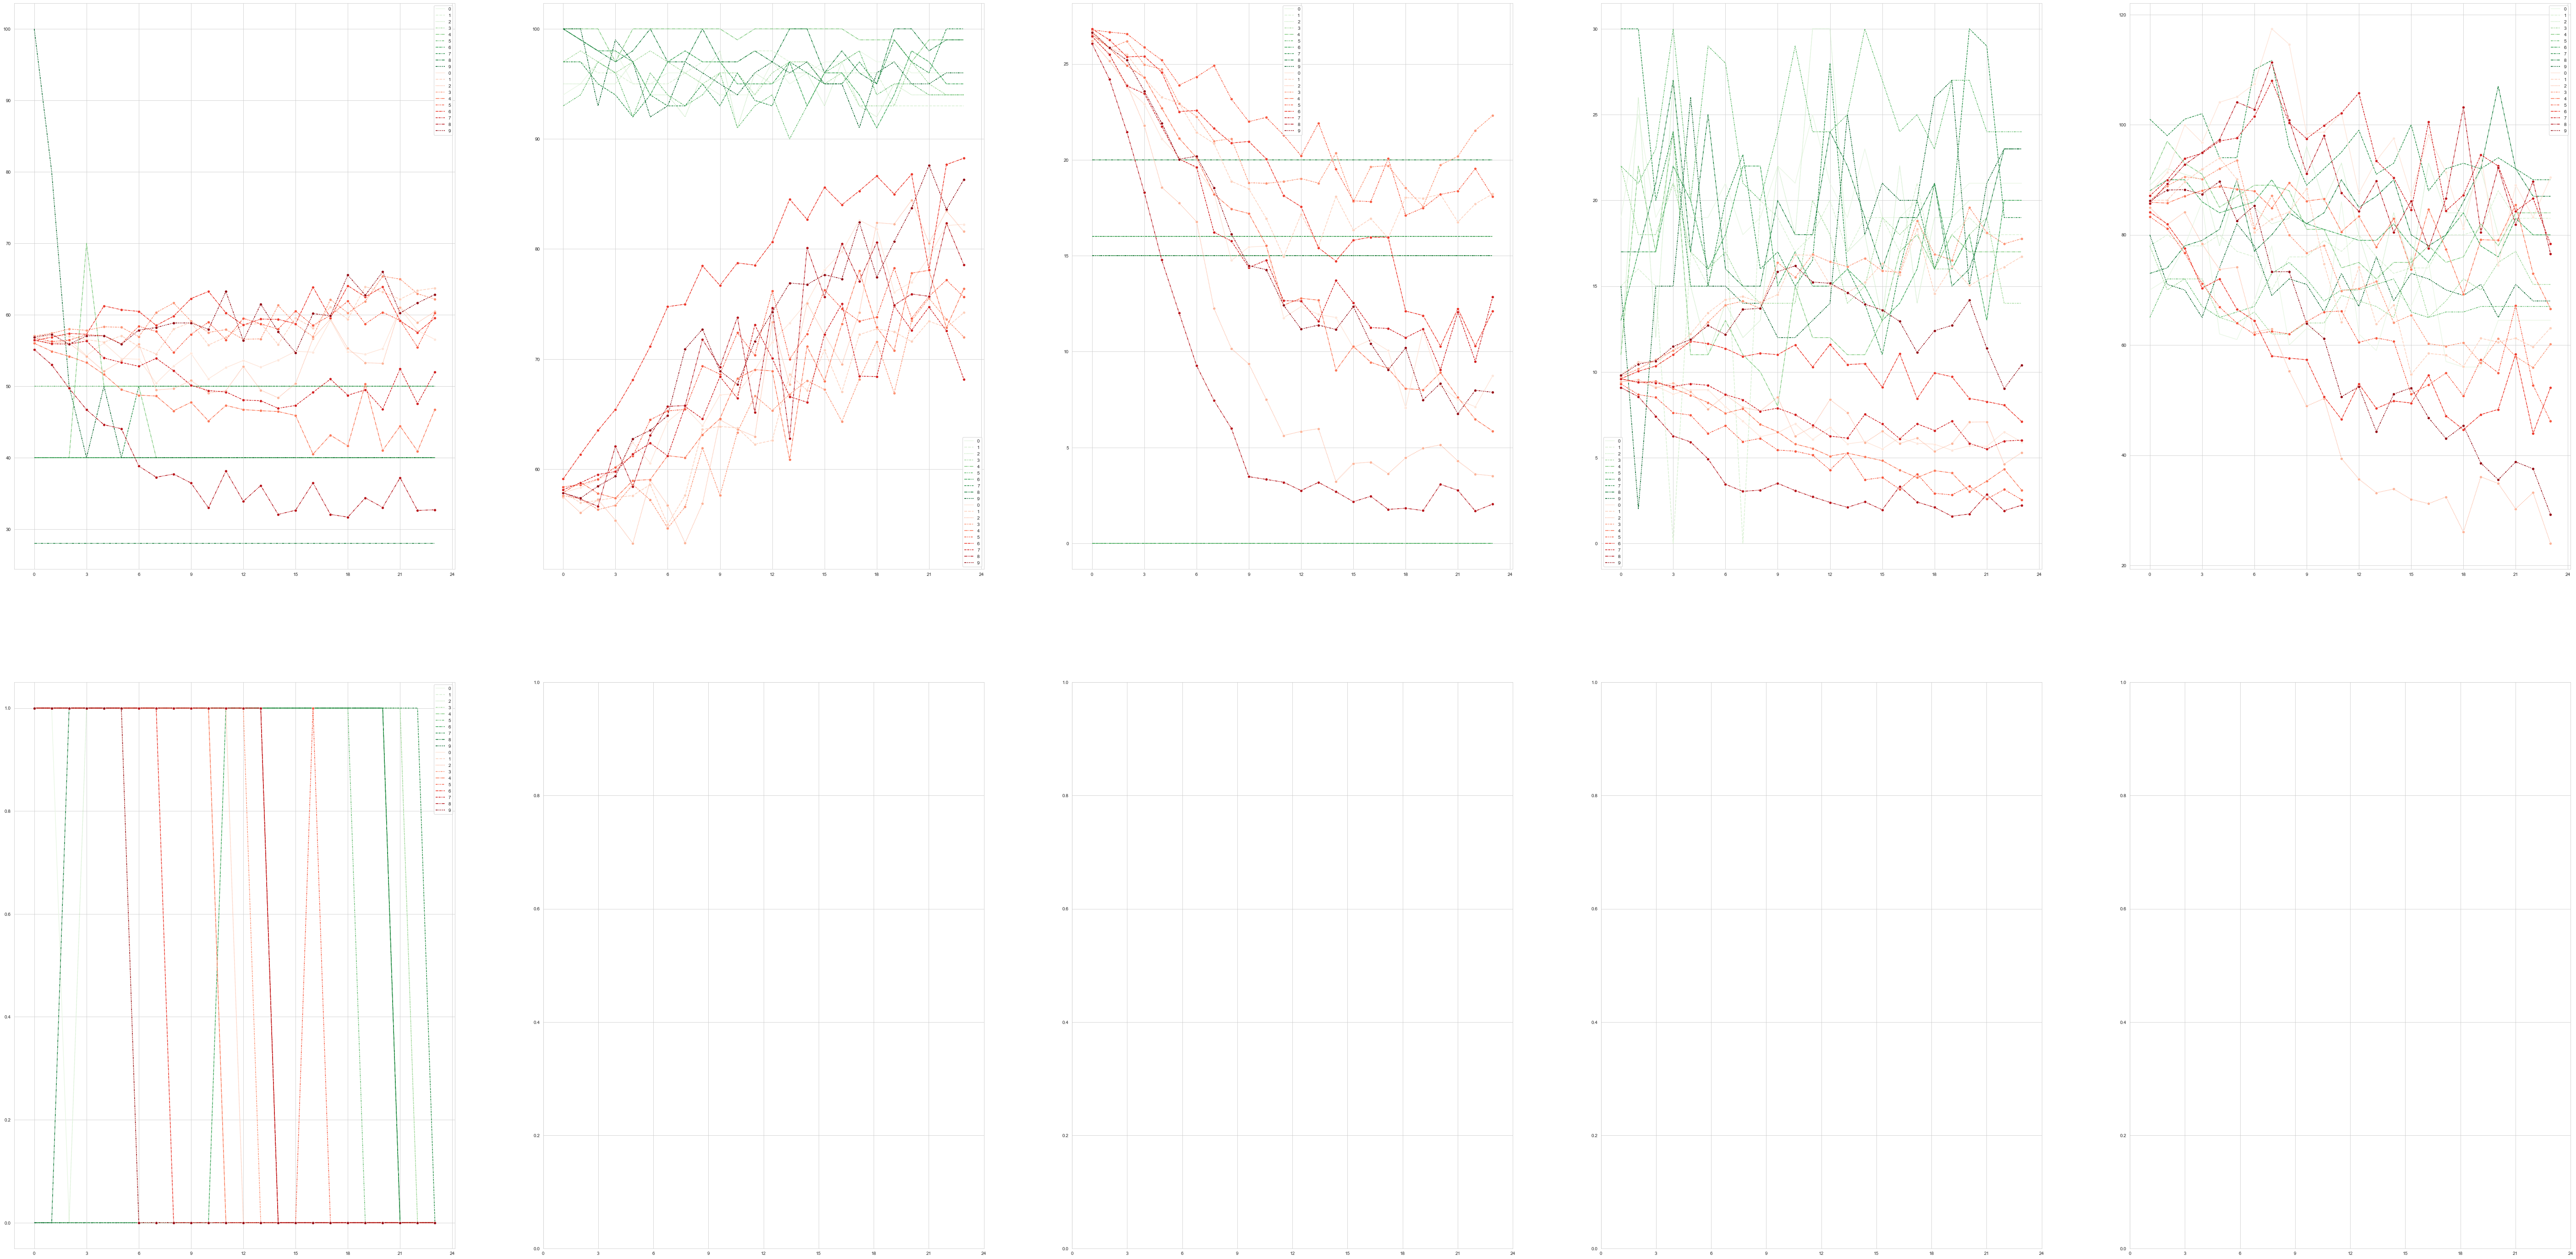

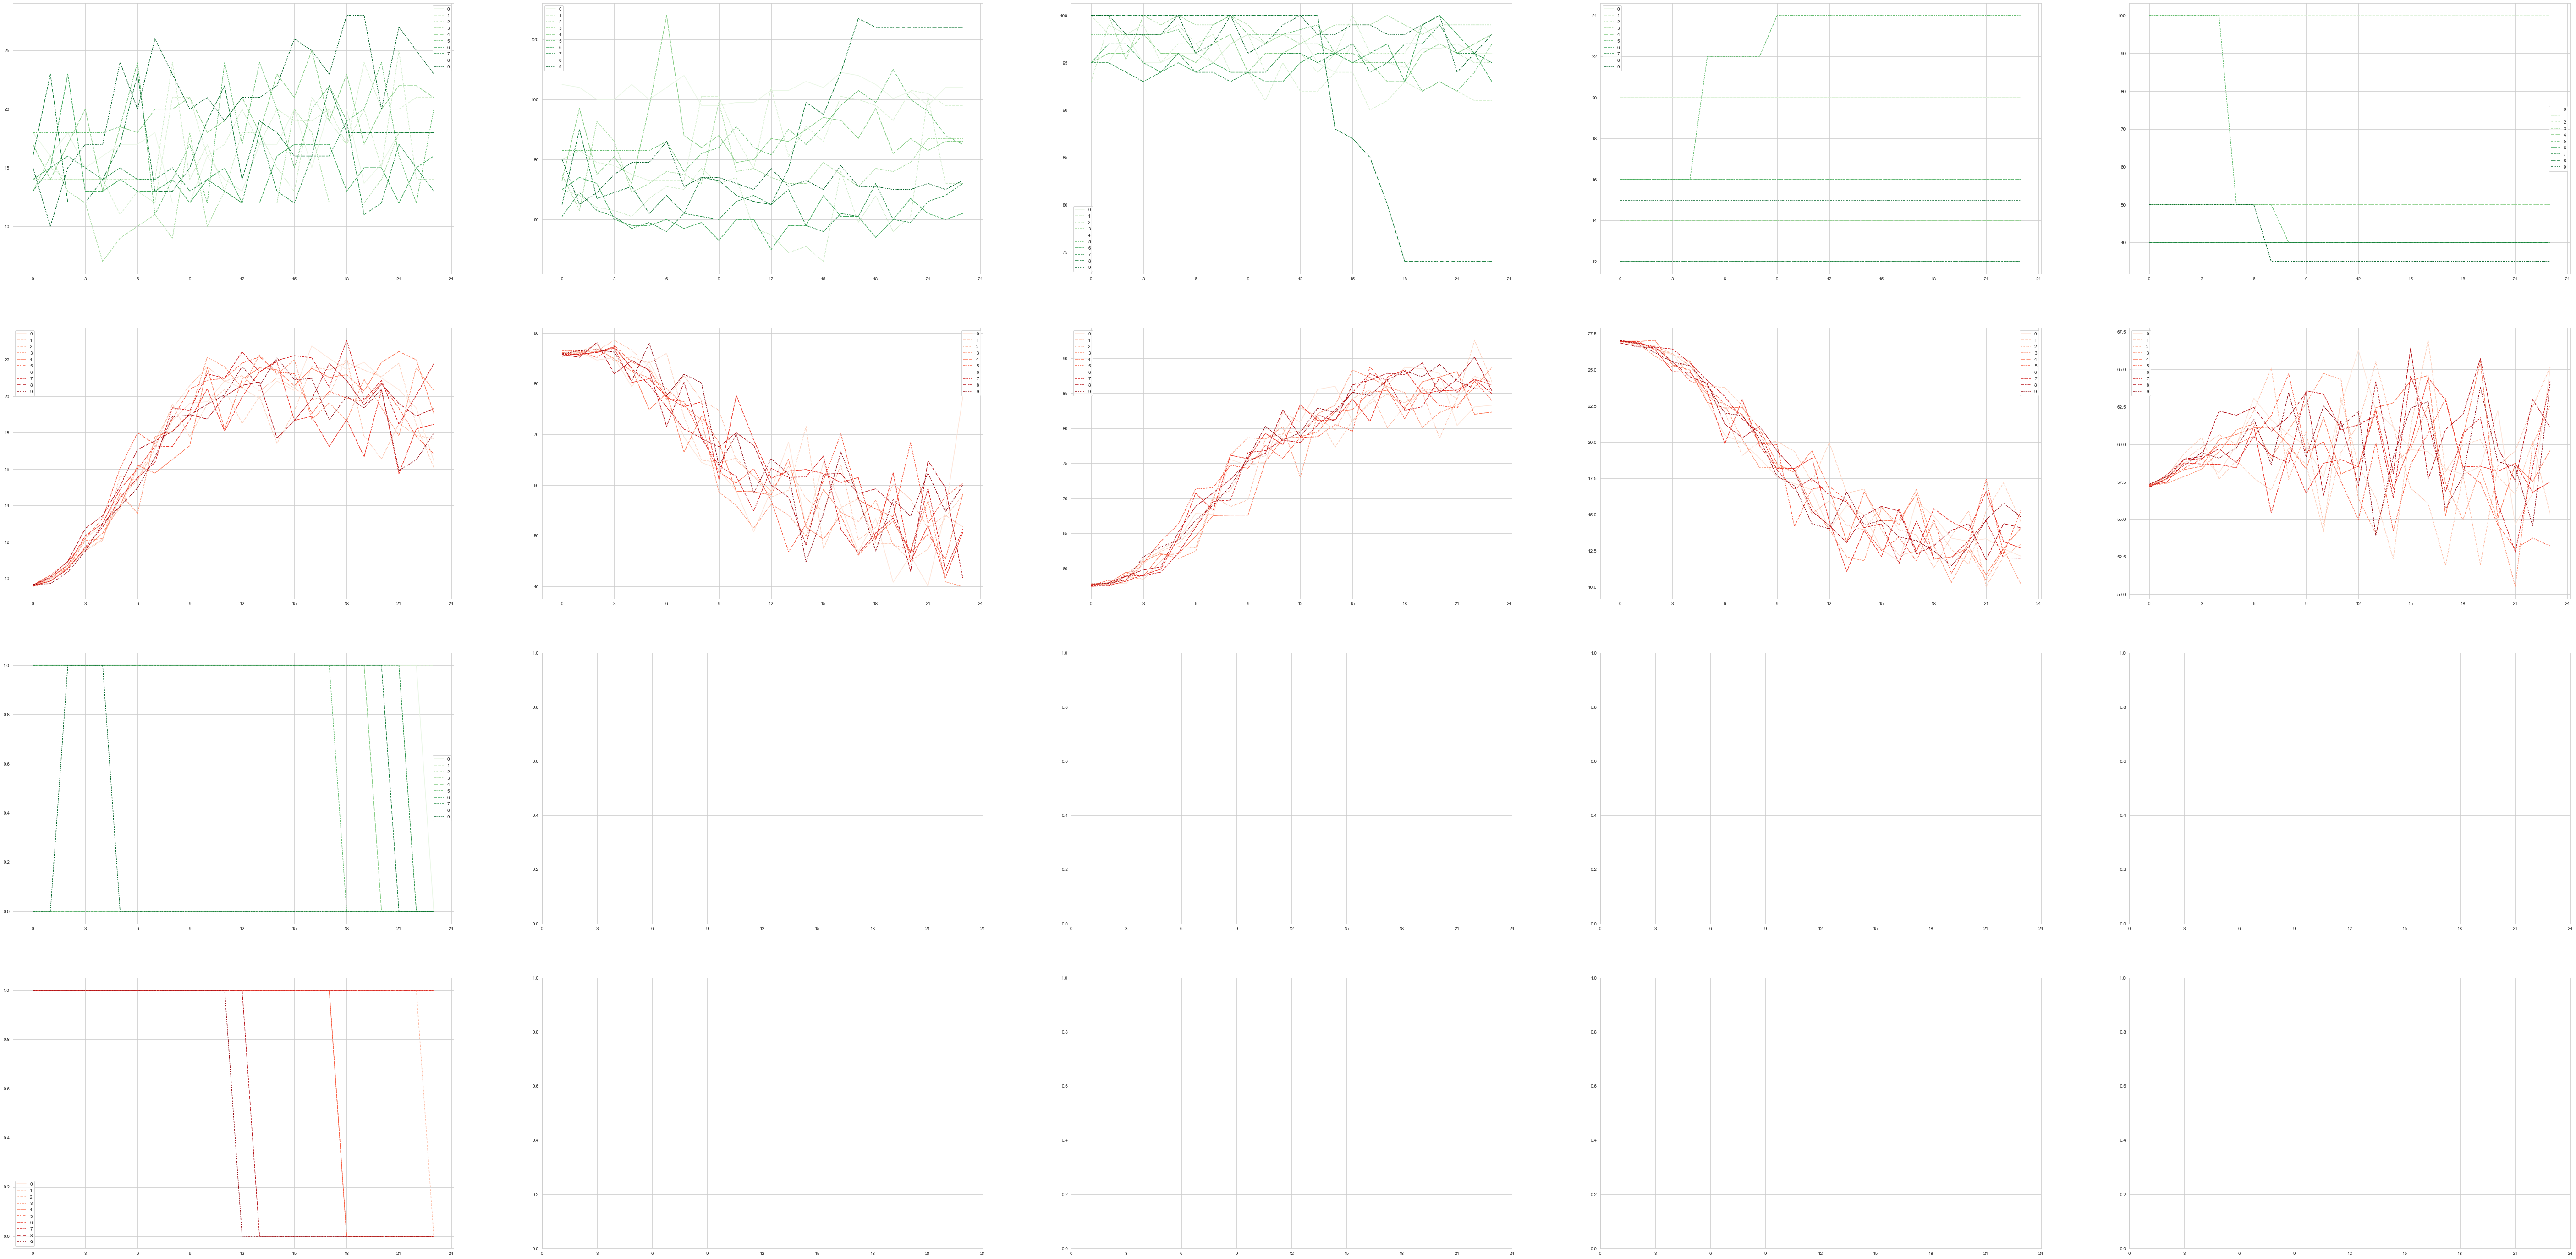

In [8]:
# REPLACE the training section (cell #8) with:
# Initialize variables or restore from checkpoint
print("Initializing or restoring model...")
checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint:
    print(f"Restoring model from checkpoint: {checkpoint}")
    # Only create the saver after the model is built
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint)
else:
    print("No checkpoint found, initializing variables")
    sess.run(tf.global_variables_initializer())

# Train the model
print("Starting training...")
start_time = timeit.default_timer()

# Only run this cell for training - you can comment it out to skip training
train_model = True
if train_model:
    model.train()
    # Save the final model - create saver only if needed to avoid variable conflicts
    if 'saver' not in locals():
        saver = tf.train.Saver()
    save_path = os.path.join(checkpoint_dir, "final_model")
    saver.save(sess, save_path)
    print(f"Model saved to {save_path}")

end_time = timeit.default_timer()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

### 7.2 Addressing First Hour Low Variance Issue
Let's analyze and fix the issue with low standard deviation in the first hour.

Generating synthetic data...
Renormalizing generated data...
Analyzing variance across time steps...


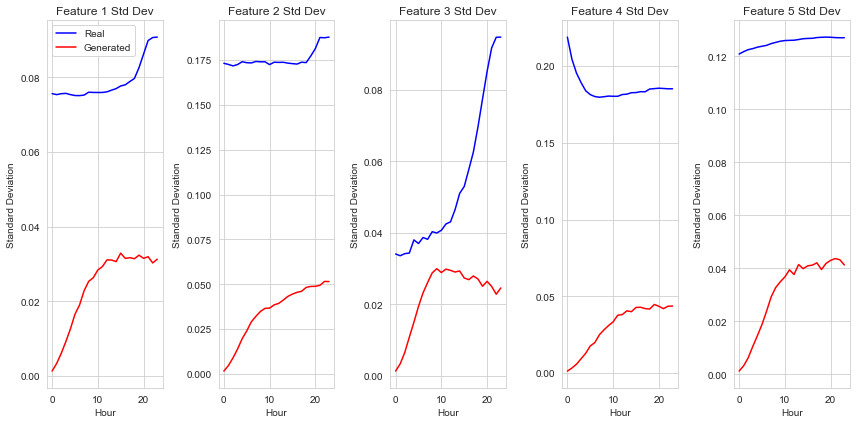


Applying variance correction to the first hour...

Applying enhanced variance correction to the first hour...


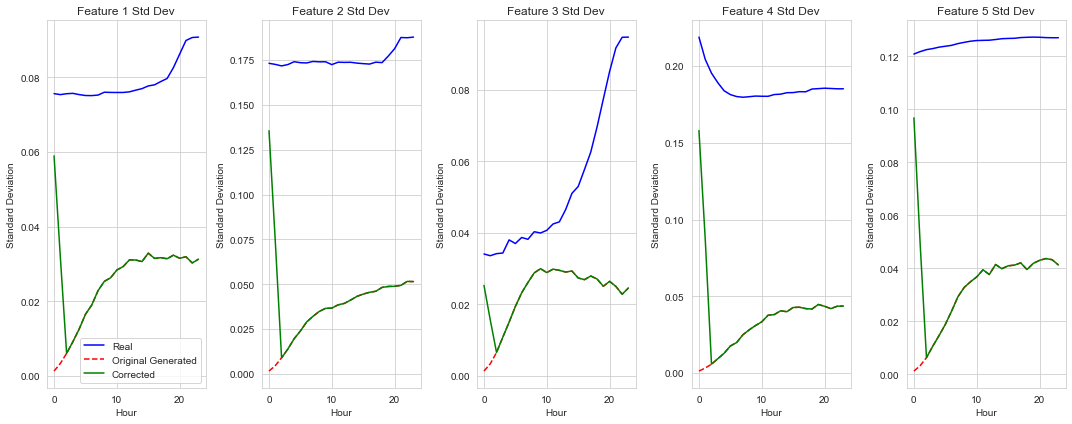

Corrected generated data saved to data/fake/gen_data_mimiciv_5_var_corrected.npz


In [ ]:
# Generate data first
print("Generating synthetic data...")
d_gen_data, c_gen_data = model.generate_data(num_sample=1024)

# Apply renormalization if your data was normalized
print("Renormalizing generated data...")
# c_gen_data_renorm = c_gen_data  # If no renormalization needed
# If renormalization needed:
# c_gen_data_renorm = renormlizer(c_gen_data, data_info) # TODO: Implement renormlizer
# renormalize
filename_postfix = '5_var'
min_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["min_val"]
max_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["max_val"]
c_gen_data_renorm = renormlizer(c_gen_data, max_val_con, min_val_con)

# Analyze the first hour variance issue
print("Analyzing variance across time steps...")
real_std_by_hour = np.std(continuous_x, axis=0)
gen_std_by_hour = np.std(c_gen_data, axis=0)

# Plot the standard deviation over time
plt.figure(figsize=(12, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Fix the low variance issue with a post-processing step
print("\nApplying variance correction to the first hour...")

# Improved variance matching function with consistency preservation
def variance_matching(data, target_std, axis=0, smoothing_factor=0.7):
    """
    Match variance of data to target_std while preserving mean and temporal consistency
    
    Args:
        data: The data to adjust
        target_std: The target standard deviation
        axis: Axis along which to compute statistics
        smoothing_factor: How much to smooth between original and adjusted values (0-1)
                         Higher means more of the original preserved
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + 1e-10  # Avoid division by zero
    
    # Normalize the data
    normalized = (data - mean) / std
    
    # Scale to target std dev and shift back to original mean
    adjusted = normalized * target_std + mean
    
    # Apply smoothing to preserve some of the original structure
    result = smoothing_factor * data + (1 - smoothing_factor) * adjusted
    
    return result

# Apply the correction to the first hour with improvements
print("\nApplying enhanced variance correction to the first hour...")
c_gen_data_corrected = c_gen_data_renorm.copy()

for i in range(c_dim):
    # First hour data
    first_hour_data = c_gen_data_corrected[:, 0, i].reshape(-1, 1)
    
    # Target std dev with slight randomization for more natural results
    target_std = real_std_by_hour[0, i] * np.random.uniform(1.0, 1.15)
    
    # Apply variance matching with trajectory consistency preservation
    c_gen_data_corrected[:, 0, i] = variance_matching(
        first_hour_data, target_std, axis=0, smoothing_factor=0.3
    ).flatten()
    
    # For natural transitions, also slightly adjust the second hour
    if time_steps > 1:
        second_hour_data = c_gen_data_corrected[:, 1, i].reshape(-1, 1)
        target_std_2 = real_std_by_hour[1, i] * np.random.uniform(0.95, 1.05)
        c_gen_data_corrected[:, 1, i] = variance_matching(
            second_hour_data, target_std_2, axis=0, smoothing_factor=0.6
        ).flatten()

# Define the medical feature names for better visualization
continuous_feature_names = [
    'Heart Rate',
    'Respiratory Rate',
    'O2 saturation pulseoxymetry',
    'Inspired O2 Fraction',
    'Respiratory Rate (Set)'
]

# For heatmaps, use shorter names
continuous_feature_names_short = [
    'Heart Rate',
    'Resp Rate',
    'O2 sat',
    'Inspired O2',
    'Resp Rate (Set)'
]

""" plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """

# Plot the standard deviation over time
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Verify the correction
corrected_std_by_hour = np.std(c_gen_data_corrected, axis=0)

plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Save the corrected data
save_path_corrected = f"data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz"
np.savez(save_path_corrected, 
         c_gen_data=c_gen_data_corrected, 
         d_gen_data=d_gen_data)
print(f"Corrected generated data saved to {save_path_corrected}")

### 7.3 Visualization and Analysis

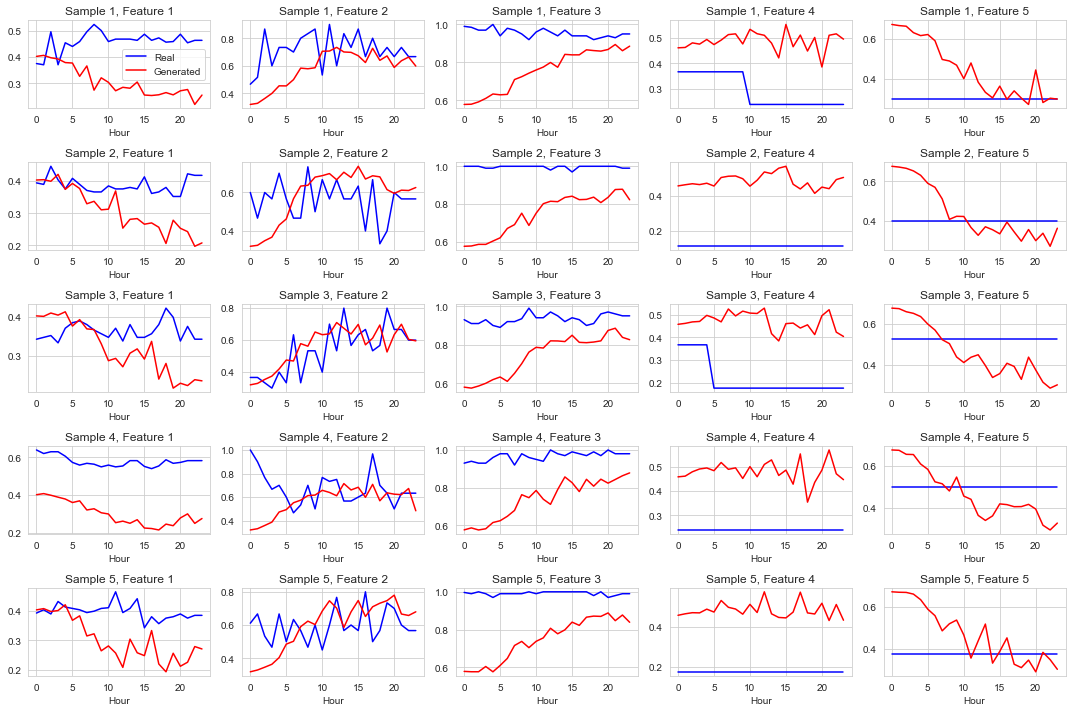

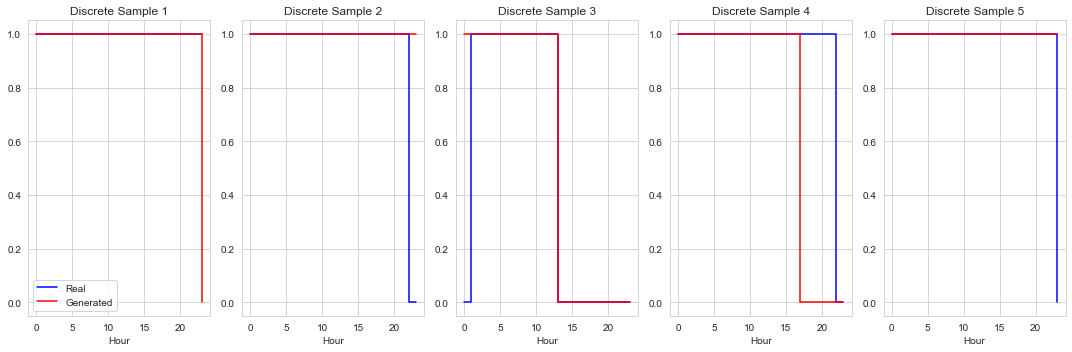

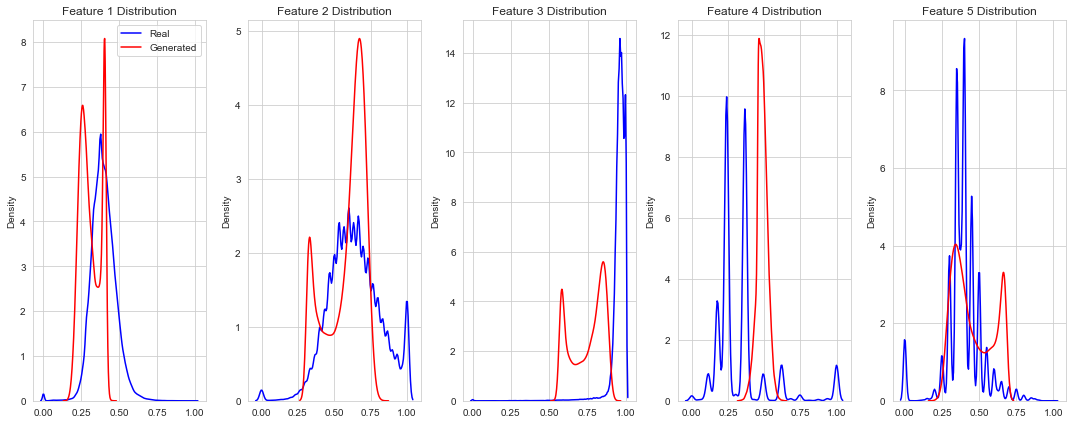

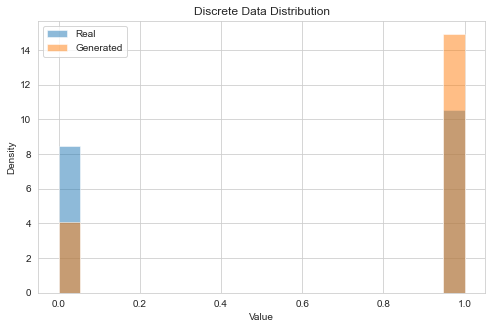

In [ ]:
# Sample and visualize a few trajectories
num_samples_to_visualize = 5
sample_indices = np.random.choice(c_gen_data.shape[0], num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    # Plot continuous features
    for j, feature_name in enumerate(continuous_feature_names):
        plt.subplot(num_samples_to_visualize, c_dim, i*c_dim + j + 1)
        plt.plot(range(time_steps), continuous_x[idx, :, j], 'b-', label='Real')
        plt.plot(range(time_steps), c_gen_data_renorm[idx, :, j], 'r-', label='Generated')
        if i == 0 and j == 0:
            plt.legend()
        plt.title(f'Sample {i+1}, {feature_name}')
        plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# For discrete data
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.step(range(time_steps), discrete_x[idx, :, 0], 'b-', where='post', label='Real')
    plt.step(range(time_steps), d_gen_data[idx, :, 0], 'r-', where='post', label='Generated')
    if i == 0:
        plt.legend()
    plt.title(f'Discrete Sample {i+1}')
    plt.xlabel('Hour')
plt.tight_layout()
plt.show()

""" # Compare distributions
plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'Feature {i+1} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """
# Compare distributions
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'{feature_name} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Discrete data distribution
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 20)
plt.hist(discrete_x.flatten(), bins=bins, alpha=0.5, label='Real', density=True)
plt.hist(d_gen_data.flatten(), bins=bins, alpha=0.5, label='Generated', density=True)
plt.legend()
plt.title('Discrete Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 8. Advanced Analysis: Preserving Medical Correlations

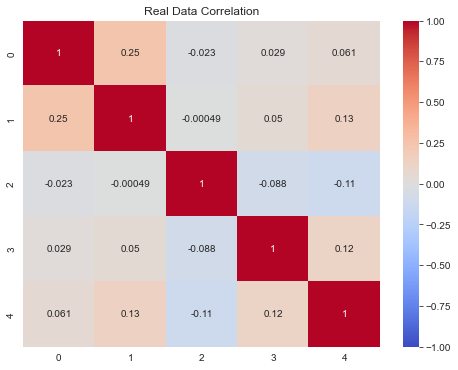

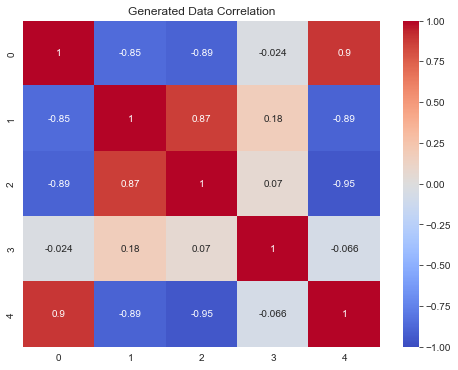

Mean absolute correlation difference: 0.4850


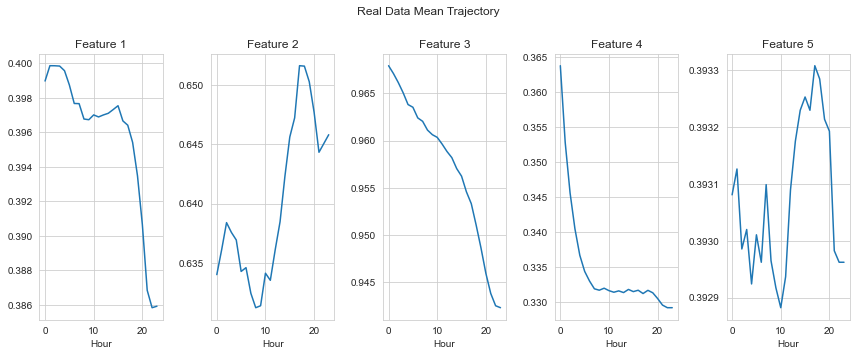

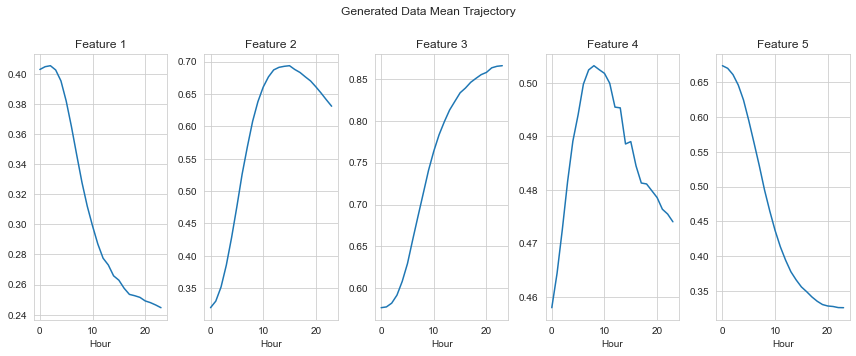

In [ ]:
# Analyze correlations between features
def plot_correlation_heatmap(data, title):
    # Reshape to (patients*times, features)
    data_flat = data.reshape(-1, data.shape[2])
    
    # Calculate correlation matrix
    corr = np.corrcoef(data_flat.T)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               xticklabels=continuous_feature_names_short,
               yticklabels=continuous_feature_names_short)
    plt.title(title)
    plt.show()
    return corr

# Plot correlation heatmaps
real_corr = plot_correlation_heatmap(continuous_x, 'Real Data Correlation')
gen_corr = plot_correlation_heatmap(c_gen_data_renorm, 'Generated Data Correlation')

# Calculate correlation difference
corr_diff = np.abs(real_corr - gen_corr)
print(f"Mean absolute correlation difference: {np.mean(corr_diff):.4f}")

# Visualize temporal patterns
def plot_mean_trajectory(data, title):
    mean_trajectory = np.mean(data, axis=0)
    
    plt.figure(figsize=(12, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, data.shape[2], i+1)
        plt.plot(range(data.shape[1]), mean_trajectory[:, i])
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_mean_trajectory(continuous_x, 'Real Data Mean Trajectory')
plot_mean_trajectory(c_gen_data_renorm, 'Generated Data Mean Trajectory')

### 9. Quantitative Evaluation

Training discriminator for continuous data...
Train on 13668 samples, validate on 3418 samples
Epoch 1/10
13668/13668 [==============================] - 6s 464us/sample - loss: 0.1368 - acc: 0.9498 - val_loss: 0.0247 - val_acc: 0.9988
Epoch 2/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0163 - acc: 0.9979 - val_loss: 0.0031 - val_acc: 0.9997
Epoch 3/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0038 - acc: 0.9996 - val_loss: 9.2341e-04 - val_acc: 0.9997
Epoch 4/10
13668/13668 [==============================] - 1s 37us/sample - loss: 0.0017 - acc: 0.9998 - val_loss: 4.3650e-04 - val_acc: 0.9997
Epoch 5/10
13668/13668 [==============================] - 1s 38us/sample - loss: 0.0017 - acc: 0.9997 - val_loss: 3.9086e-04 - val_acc: 0.9997
Epoch 6/10
13668/13668 [==============================] - 1s 38us/sample - loss: 7.2200e-04 - acc: 0.9999 - val_loss: 1.1091e-04 - val_acc: 1.0000
Epoch 7/10
13668/13668 [==========================

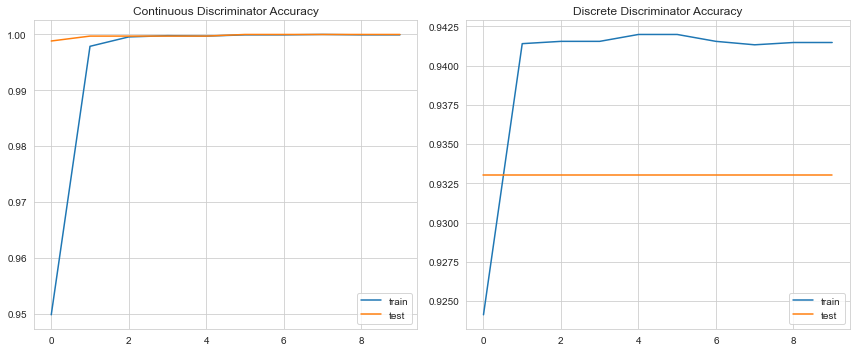

In [12]:
# Train a model to distinguish real from generated data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple discriminator model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' for TF1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
print("Training discriminator for continuous data...")
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data_renorm)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

print("\nTraining discriminator for discrete data...")
d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# In an ideal GAN, AUC should be close to 0.5 (indistinguishable)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')
plt.plot(c_history.history['val_acc'], label='test')
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')
plt.plot(d_history.history['val_acc'], label='test')
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 10. Summary and Recommendations

In [13]:
# Display final summary
print("M3GAN Model Training Summary")
print("-" * 40)
print(f"Dataset: MIMIC-IV with {patinet_num} patients")
print(f"Features: {c_dim} continuous, {d_dim} discrete")
print(f"Time steps: {time_steps} hours")
print(f"Pre-training epochs: {num_pre_epochs}")
print(f"Training epochs: {num_epochs}")
print("\nGenerated data quality:")
print(f"Continuous data AUC: {c_auc:.4f} (closer to 0.5 is better)")
print(f"Discrete data AUC: {d_auc:.4f} (closer to 0.5 is better)")
print(f"Mean correlation difference: {np.mean(corr_diff):.4f} (lower is better)")
print("\nTraining files:")
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Generated data: data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz")

# Recommendations
print("\nRecommendations:")
print("1. For low variance in first hour: Applied variance matching as a post-processing step")
print("2. For better stability: Consider using gradient penalty or spectral normalization")
print("3. For better feature correlations: Increase the alpha_mt parameter")
print("4. For more realistic trajectories: Increase the number of GAN training epochs")
print("5. For more diverse samples: Consider reducing batch size or adding noise during generation")

M3GAN Model Training Summary
----------------------------------------
Dataset: MIMIC-IV with 16062 patients
Features: 5 continuous, 1 discrete
Time steps: 24 hours
Pre-training epochs: 3
Training epochs: 5

Generated data quality:
Continuous data AUC: 1.0000 (closer to 0.5 is better)
Discrete data AUC: 0.9015 (closer to 0.5 is better)
Mean correlation difference: 0.4850 (lower is better)

Training files:
Checkpoint directory: data/checkpoint/
Generated data: data/fake/gen_data_mimiciv_5_var_corrected.npz

Recommendations:
1. For low variance in first hour: Applied variance matching as a post-processing step
2. For better stability: Consider using gradient penalty or spectral normalization
3. For better feature correlations: Increase the alpha_mt parameter
4. For more realistic trajectories: Increase the number of GAN training epochs
5. For more diverse samples: Consider reducing batch size or adding noise during generation


### 11. Close Session

In [ ]:
# Close the TensorFlow session
# TODO: Uncomment to close the session!!!
# sess.close()
# print("TensorFlow session closed")

TensorFlow session closed
